In [162]:
import numpy as np

import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

## Gradient projection

In [163]:
def _dot(a, b):
    return sum(np.dot(x.ravel(), y.ravel()) for x, y in zip(a, b))

class ExponentialFamilyDistribution:
    def __init__(self, *theta):
        self.theta = theta
        
    def A(self):
        return NotImplemented
    
    def T(self, x):
        return NotImplemented
    
    def h(self, x):
        return NotImplemented
    
    def pdf(self, *x):
        return self.h(*x) * np.exp(_dot(self.theta, self.T(*x)) - self.A())
    
    def sample(self):
        raise NotImplemented
    

class GaussianDistribution(ExponentialFamilyDistribution):
    def __init__(self, *theta):
        super().__init__(*theta)
        self.k = theta[0].shape[0]
    
    def A(self):
        return 0.5 * _dot(self.theta, self.theta)
    
    def grad_A(self):
        return self.theta
    
    def T(self, x):
        return x
    
    def h(self, x):
        return (2 * np.pi) ** (-self.k / 2) * np.exp(-0.5 * _dot(x, x))
        
    def sample(self):
        return (np.random.normal(loc=self.theta[0]), )

In [164]:
def projector(x):
    return np.clip(x, -0.5, 0.5)

In [165]:
def projected_gradient(obj, f_class, projector, C, theta0, n_iters=5000):
    estimations = []
    thetas = [theta0]
    
    cumsum = 0
    theta = theta0
    for i in range(1, n_iters + 1):
        f = f_class(theta)
        x = f.sample()
        cumsum += obj(x) / f.pdf(x)
        estimations.append(cumsum / i)
        
        tmp = (obj(x) / f.pdf(x)) ** 2
        g = tuple(tmp * (a - b) for a, b in zip(f.grad_A(), f.T(x)))
        theta = projector(theta - C / i ** 0.5 * g[0])
        thetas.append((theta, ))
        
    return thetas, estimations

In [166]:
obj = lambda x: 1 <= _dot(x, x) <= 4

In [178]:
%%time
thetas, estimations = projected_gradient(obj, GaussianDistribution, projector, 
                                         0.001, np.array([-3, 10]), n_iters = 15000)

CPU times: user 1.29 s, sys: 33.7 ms, total: 1.32 s
Wall time: 1.31 s


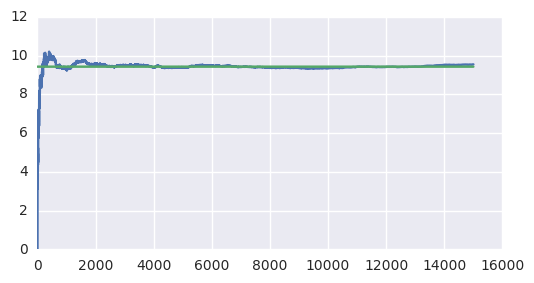

In [179]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(estimations))
plt.plot(range(15000), 3 * np.pi * np.ones(15000))

## Mirror descent

We first assume that $w(x) = x \log x$

In [169]:
def mirror (x, g, alpha, dgf = 'xlogx'):
    n = len(x)
    norm_const = x * np.exp(- alpha * g).sum()
    updated_x = [x[i] * np.exp(- alpha * g[i]) for i in range(n)] / norm_const
    return updated_x

In [170]:
def mirror_update(obj, f_class, mirror, C, theta0, n_iters=5000):
    estimations = []
    thetas = [theta0]
    
    cumsum = 0
    theta = theta0
    for i in range(1, n_iters + 1):
        f = f_class(theta)
        x = f.sample()
        cumsum += obj(x) / f.pdf(x)
        estimations.append(cumsum / i)
        
        tmp = (obj(x) / f.pdf(x)) ** 2
        g = tuple(tmp * (a - b) for a, b in zip(f.grad_A(), f.T(x)))
        alpha = C / i ** 0.5
        theta = mirror(theta, g[0], alpha) #  - C / i ** 0.5 * 
        thetas.append((theta, ))
        
    return thetas, estimations

In [171]:
thetas, estimations = mirror_update(obj, GaussianDistribution, mirror, 
                                         0.01, np.array([-3, 10]))

In [172]:
obj = lambda x: 1 <= _dot(x, x) <= 4
#obj = lambda x: np.linalg.norm(x) <= 1

In [180]:
thetas, estimations = mirror_update(obj, GaussianDistribution, mirror, 
                                         0.001, np.array([-3, 10]), n_iters=15000)

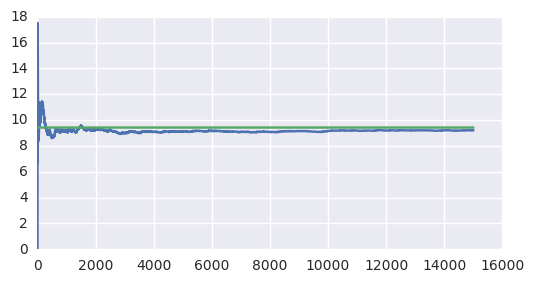

In [181]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(estimations))
plt.plot(range(15000), 3 * np.pi * np.ones(15000))